In [6]:
!pip install alpha_vantage

In [7]:
import pandas as pd
import requests
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:


# Define the Alpha Vantage API key
ALPHA_VANTAGE_API_KEY = "29OJUGYKDIOMMM0Q"  

class StockAnalysisPipeline:
    def __init__(self, stock_symbol, api_key):
        """
        Initialize the pipeline with the stock symbol and API key.
        """
        self.stock_symbol = stock_symbol
        self.api_key = api_key
        self.raw_data = None
        self.cleaned_data = None

    def fetch_stock_data(self):
        """
        Fetch daily stock data for the given symbol from Alpha Vantage API.
        """
        print(f"Fetching stock data for {self.stock_symbol}...")
        url = "https://www.alphavantage.co/query"
        params = {
            "function": "TIME_SERIES_DAILY",
            "symbol": self.stock_symbol,
            "apikey": self.api_key
        }
        response = requests.get(url, params=params)
        data = response.json().get("Time Series (Daily)", {})

        # Convert data to pandas DataFrame
        stock_data = pd.DataFrame.from_dict(data, orient="index")
        stock_data.columns = ["open", "high", "low", "close", "volume"]
        stock_data.index = pd.to_datetime(stock_data.index)
        self.raw_data = stock_data.apply(pd.to_numeric)
        print("Stock data successfully fetched.")
        return self.raw_data

    def clean_and_process_data(self):
        """
        Clean and process the raw stock data, adding moving averages.
        """
        if self.raw_data is None:
            raise ValueError("Raw data is missing. Please run `fetch_stock_data` first.")

        print("Processing stock data...")
        self.cleaned_data = self.raw_data.copy()

        # Calculate the 30-day moving average of closing prices
        self.cleaned_data["moving_avg_30"] = self.cleaned_data["close"].rolling(window=30).mean()

        # Drop rows with missing values after calculating the moving average
        self.cleaned_data.dropna(inplace=True)

        print("Data processing completed.")
        return self.cleaned_data

    def generate_recommendations(self):
        """
        Analyze the processed data and provide a stock recommendation.
        """
        if self.cleaned_data is None:
            raise ValueError("Processed data is missing. Please run `clean_and_process_data` first.")

        print("Generating stock recommendation...")
        last_close_price = self.cleaned_data["close"].iloc[-1]
        last_moving_avg = self.cleaned_data["moving_avg_30"].iloc[-1]

        # Generate recommendation based on closing price and moving average
        recommendation = "Buy" if last_close_price > last_moving_avg else "Hold"

        # Create a summary of the recommendation
        recommendation_summary = {
            "symbol": self.stock_symbol,
            "date": datetime.now(),
            "recommendation": recommendation,
            "last_close_price": last_close_price,
            "last_moving_avg": last_moving_avg
        }

        print("Recommendation generated:")
        for key, value in recommendation_summary.items():
            print(f"{key}: {value}")

        return recommendation_summary

    def execute_pipeline(self):
        """
        Execute the full analysis pipeline.
        """
        self.fetch_stock_data()  # Fetch stock data
        self.clean_and_process_data()  # Clean and process data
        return self.generate_recommendations()  # Generate and return recommendations


# Example usage
if __name__ == "__main__":
    stock_symbol = "AAPL"  # Set the stock symbol you want to track
    analysis_pipeline = StockAnalysisPipeline(stock_symbol, ALPHA_VANTAGE_API_KEY)

    # Run the full analysis pipeline and get stock recommendation
    recommendation_result = analysis_pipeline.execute_pipeline()



Fetching stock data for AAPL...
Stock data successfully fetched.
Processing stock data...
Data processing completed.
Generating stock recommendation...
Recommendation generated:
symbol: AAPL
date: 2024-11-20 10:11:08.167293
recommendation: Hold
last_close_price: 216.75
last_moving_avg: 221.75966666666667


In [9]:


# Define the feature selection class
class FeatureSelector:
    def __init__(self, data):
        """
        Initialize with a DataFrame containing features and target.
        """
        self.data = data
        self.selected_features = None

    def variance_threshold_selector(self, threshold=0.01):
        """
        Removes features with low variance.
        """
        print("[Feature Selection: Variance Threshold] Removing low-variance features...")
        selector = VarianceThreshold(threshold=threshold)
        reduced_data = selector.fit_transform(self.data)
        kept_columns = self.data.columns[selector.get_support()]
        print(f"[Feature Selection] Features retained after variance threshold: {list(kept_columns)}")
        return self.data[kept_columns]

    def correlation_filter(self, target_column, threshold=0.75):
        """
        Removes features highly correlated with each other or the target.
        """
        print("[Feature Selection: Correlation Filter] Analyzing correlations...")
        corr_matrix = self.data.corr()

        # Ensure the target_column exists in the data
        if target_column not in corr_matrix.columns:
            print(f"Error: {target_column} not found in correlation matrix.")
            return self.data

        # Ensure the target_column is correctly referenced
        target_corr = corr_matrix[target_column].abs().sort_values(ascending=False)
        print("[Correlation with Target]")
        print(target_corr)

        # Remove features with high correlation with others (above the threshold)
        high_corr_features = set()
        for i in corr_matrix.columns:
            for j in corr_matrix.columns:
                if i != j and abs(corr_matrix.loc[i, j]) > threshold:
                    high_corr_features.add(j)

        kept_features = [col for col in self.data.columns if col not in high_corr_features]
        print(f"[Feature Selection] Features retained after correlation filter: {kept_features}")
        return self.data[kept_features]

    def lasso_selector(self, target_column, alpha=0.01):
        """
        Selects features using L1 regularization (Lasso).
        """
        print("[Feature Selection: Lasso] Applying Lasso regression for feature selection...")
        X = self.data.drop(columns=[target_column])
        y = self.data[target_column]

        # Train Lasso model
        lasso = Lasso(alpha=alpha)
        lasso.fit(X, y)

        # Get non-zero coefficients (important features)
        selected_features = X.columns[(lasso.coef_ != 0)]
        print(f"[Feature Selection] Features retained after Lasso: {list(selected_features)}")
        return self.data[selected_features.tolist() + [target_column]]

    def rfe_selector(self, target_column, n_features=5):
        """
        Selects top features using Recursive Feature Elimination (RFE).
        """
        print("[Feature Selection: RFE] Applying Recursive Feature Elimination...")
        X = self.data.drop(columns=[target_column])
        y = self.data[target_column]

        # Train RFE model
        rf = RandomForestRegressor(random_state=42)
        rfe = RFE(rf, n_features_to_select=n_features)
        rfe.fit(X, y)

        # Get features selected by RFE
        selected_features = X.columns[rfe.support_]
        print(f"[Feature Selection] Features retained after RFE: {list(selected_features)}")
        return self.data[selected_features.tolist() + [target_column]]

    def univariate_selector(self, target_column, k=5):
        """
        Selects top features based on univariate statistical tests (ANOVA F-test).
        """
        print("[Feature Selection: Univariate] Applying univariate feature selection...")
        X = self.data.drop(columns=[target_column])
        y = self.data[target_column]

        # Use SelectKBest to select features based on ANOVA F-test
        selector = SelectKBest(score_func=f_classif, k=k)
        X_new = selector.fit_transform(X, y)

        # Get top k features
        selected_features = X.columns[selector.get_support()]
        print(f"[Feature Selection] Features retained after univariate selection: {list(selected_features)}")
        return self.data[selected_features.tolist() + [target_column]]

    def feature_importance(self, target_column, n_features=5):
        """
        Selects top features based on importance from a RandomForest model.
        """
        print("[Feature Selection: Feature Importance] Evaluating with RandomForest...")
        X = self.data.drop(columns=[target_column])
        y = self.data[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Extract feature importances
        importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        print("[Feature Importance Ranking]")
        print(importances)

        # Select top features
        top_features = importances.head(n_features)["Feature"].tolist()
        print(f"[Feature Selection] Top {n_features} features: {top_features}")
        return self.data[top_features + [target_column]]

    def run_all(self, target_column, strategy='all'):
        """
        Runs all feature selection strategies or the selected strategy.
        """
        print("[Feature Selection Pipeline] Starting...")

        if strategy == 'variance':
            filtered_data = self.variance_threshold_selector()
        elif strategy == 'correlation':
            filtered_data = self.correlation_filter(target_column, threshold=0.75)
        elif strategy == 'lasso':
            filtered_data = self.lasso_selector(target_column, alpha=0.01)
        elif strategy == 'rfe':
            filtered_data = self.rfe_selector(target_column, n_features=5)
        elif strategy == 'univariate':
            filtered_data = self.univariate_selector(target_column, k=5)
        elif strategy == 'importance':
            filtered_data = self.feature_importance(target_column, n_features=5)
        else:  # Default to running all strategies
            filtered_data = self.variance_threshold_selector()
            filtered_data = self.correlation_filter(target_column, threshold=0.75)
            filtered_data = self.feature_importance(target_column, n_features=5)

        print("[Feature Selection Pipeline] Completed.")
        self.selected_features = filtered_data.columns
        return filtered_data


def collect_stock_data(symbol, api_key):
    """
    Collects stock data from Alpha Vantage API and adds simple features.
    """
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')

    # Use adjusted close price
    stock_data = data[['4. close', '1. open', '2. high', '3. low', '5. volume']]
    stock_data.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'}, inplace=True)

    # Simple Moving Averages (SMA)
    stock_data['sma_5'] = stock_data['Close'].rolling(window=5).mean()  # 5-day SMA
    stock_data['sma_20'] = stock_data['Close'].rolling(window=20).mean()  # 20-day SMA

    # Price Change (Day-to-Day Change)
    stock_data['price_change'] = stock_data['Close'].diff()

    # Moving Average Difference (Difference between 20-day and 5-day SMA)
    stock_data['sma_diff'] = stock_data['sma_20'] - stock_data['sma_5']

    # Lagged Price (Previous Day's Closing Price)
    stock_data['lagged_close'] = stock_data['Close'].shift(1)

    # Volume Moving Average (20-day average of trading volume)
    stock_data['volume_avg_20'] = stock_data['Volume'].rolling(window=20).mean()

    # Percentage Change (Daily Return)
    stock_data['daily_return'] = stock_data['Close'].pct_change() * 100  # Daily return in percentage

    # Price-to-Volume Trend (PVT)
    stock_data['pvt'] = (stock_data['Volume'] * (stock_data['Close'].pct_change())).cumsum()

    # Drop NaN values created by rolling and shifting operations
    stock_data.dropna(inplace=True)

    return stock_data


if __name__ == "__main__":
    STOCK_SYMBOL = "AAPL"  # Stock symbol to track
    API_KEY = "29OJUGYKDIOMMM0Q"  # Replace with your Alpha Vantage API key

    # Fetch stock data
    stock_data = collect_stock_data(STOCK_SYMBOL, API_KEY)

    if stock_data is not None and not stock_data.empty:
        # Initialize feature selector with the stock data
        fs = FeatureSelector(stock_data)

        # Run the feature selection pipeline
        selected_data = fs.run_all(target_column="daily_return", strategy="all")  

        # Display the final selected features
        print("\n[Final Selected Data]")
        print(selected_data.head())  


[Feature Selection Pipeline] Starting...
[Feature Selection: Variance Threshold] Removing low-variance features...
[Feature Selection] Features retained after variance threshold: ['Close', 'Open', 'High', 'Low', 'Volume', 'sma_5', 'sma_20', 'price_change', 'sma_diff', 'lagged_close', 'volume_avg_20', 'daily_return', 'pvt']
[Feature Selection: Correlation Filter] Analyzing correlations...
[Correlation with Target]
daily_return     1.000000
price_change     0.927063
sma_diff         0.074892
Low              0.043007
Open             0.042981
Close            0.042759
High             0.042648
volume_avg_20    0.038411
pvt              0.018017
lagged_close     0.016817
sma_20           0.014004
Volume           0.005759
sma_5            0.004813
Name: daily_return, dtype: float64
[Feature Selection] Features retained after correlation filter: ['sma_diff']
[Feature Selection: Feature Importance] Evaluating with RandomForest...
[Feature Importance Ranking]
          Feature  Importance
7 

In [27]:
def collect_stock_data(symbol, api_key):
    """
    Collects stock data from Alpha Vantage API and adds simple features.
    """
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')

    # Use adjusted close price
    stock_data = data[['4. close', '1. open', '2. high', '3. low', '5. volume']]
    stock_data.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'}, inplace=True)

    # Simple Moving Averages (SMA)
    stock_data['sma_5'] = stock_data['Close'].rolling(window=5).mean()  # 5-day SMA
    stock_data['sma_20'] = stock_data['Close'].rolling(window=20).mean()  # 20-day SMA

    # Price Change (Day-to-Day Change)
    stock_data['price_change'] = stock_data['Close'].diff()

    # Moving Average Difference (Difference between 20-day and 5-day SMA)
    stock_data['sma_diff'] = stock_data['sma_20'] - stock_data['sma_5']

    # Lagged Price (Previous Day's Closing Price)
    stock_data['lagged_close'] = stock_data['Close'].shift(1)

    # Volume Moving Average (20-day average of trading volume)
    stock_data['volume_avg_20'] = stock_data['Volume'].rolling(window=20).mean()

    # Percentage Change (Daily Return)
    stock_data['daily_return'] = stock_data['Close'].pct_change() * 100  # Daily return in percentage

    # Price-to-Volume Trend (PVT)
    stock_data['pvt'] = (stock_data['Volume'] * (stock_data['Close'].pct_change())).cumsum()

    # Drop NaN values created by rolling and shifting operations
    stock_data.dropna(inplace=True)  # Dropping rows with NaN values

    return stock_data


In [30]:
class FeatureCombiner:
    def __init__(self, data):
        """
        Initialize with a DataFrame containing the selected features.
        """
        self.data = data

    def run_all(self):
        """
        Combine features and return the final dataset.
        """
        # The combined data can be simply the selected features or processed data.
        print("[FeatureCombiner] Combining selected features...")
        return self.data

if __name__ == "__main__":
    # Example: Assuming 'featured_data' is already available from previous feature selection pipeline
    featured_data = stock_data  # stock_data comes from previous steps

    # Initialize feature combiner with the selected featured data
    feature_combiner = FeatureCombiner(featured_data)
    combined_data = feature_combiner.run_all()

    # Display the final combined data
    print("\n[Final Combined Data]")
    print(combined_data.head())


[FeatureCombiner] Combining selected features...

[Final Combined Data]
               Open     High     Low   Close      Volume    sma_5    sma_20  \
2024-10-23  234.080  235.144  227.76  230.76  52286979.0  231.962  227.2225   
2024-10-22  233.885  236.220  232.60  235.86  38846578.0  232.400  227.6015   
2024-10-21  234.450  236.850  234.45  236.48  36254470.0  233.016  228.0245   
2024-10-18  236.180  236.180  234.01  235.00  46431472.0  233.734  228.5245   
2024-10-17  233.430  233.850  230.52  232.15  32993810.0  234.050  228.7210   

            price_change  sma_diff  lagged_close  volume_avg_20  daily_return  \
2024-10-23          0.19   -4.7395        230.57    44160994.60      0.082404   
2024-10-22          5.10   -4.7985        230.76    44292734.80      2.210088   
2024-10-21          0.62   -4.9915        235.86    43871157.30      0.262868   
2024-10-18         -1.48   -5.2095        236.48    43796546.10     -0.625846   
2024-10-17         -2.85   -5.3290        235.00

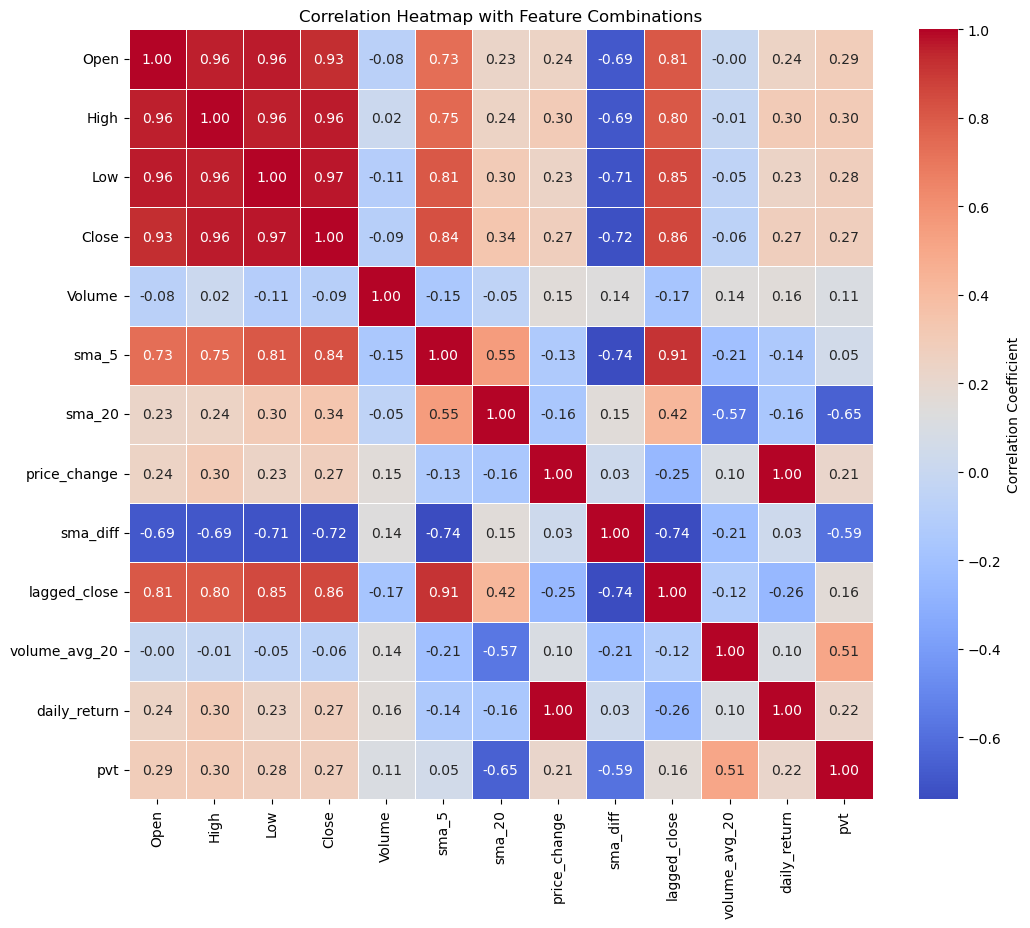

In [32]:

# Calculate correlation matrix
correlation_matrix = combined_data.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))  # Adjusting the figure size for better visibility
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Heatmap with Feature Combinations")
plt.show()

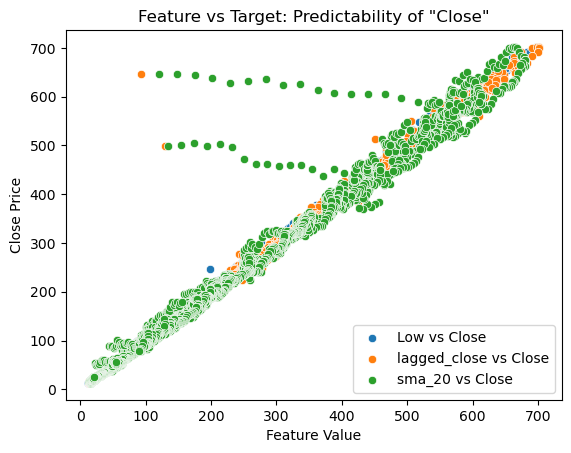

In [33]:
# Loop over the top correlated features and create scatter plots
for feature in top_features:
    sns.scatterplot(data=selected_data, x=feature, y='Close', label=f'{feature} vs Close')

# Adding labels and title
plt.title('Feature vs Target: Predictability of "Close"')
plt.xlabel('Feature Value')
plt.ylabel('Close Price')
plt.legend()
plt.show()


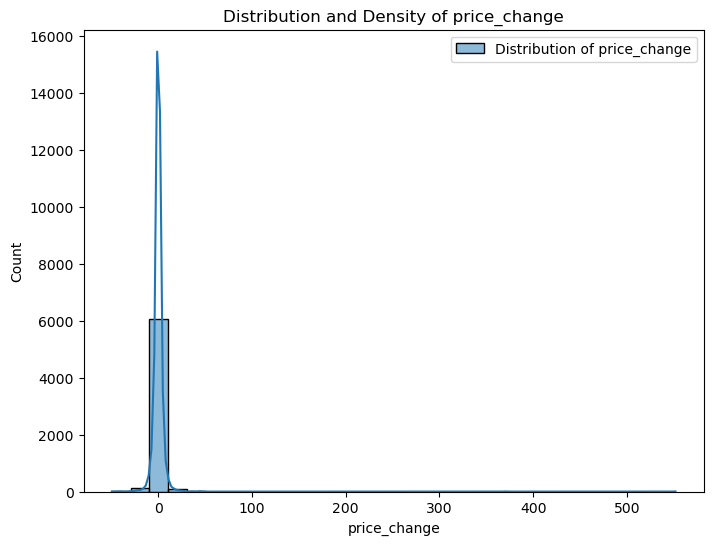

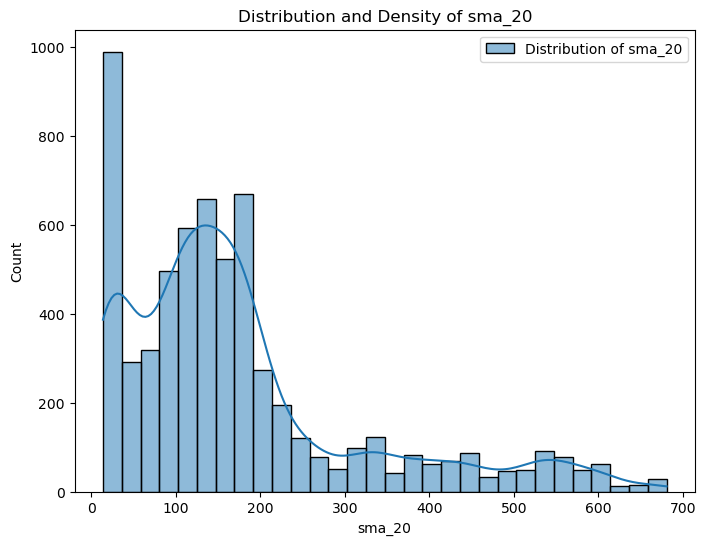

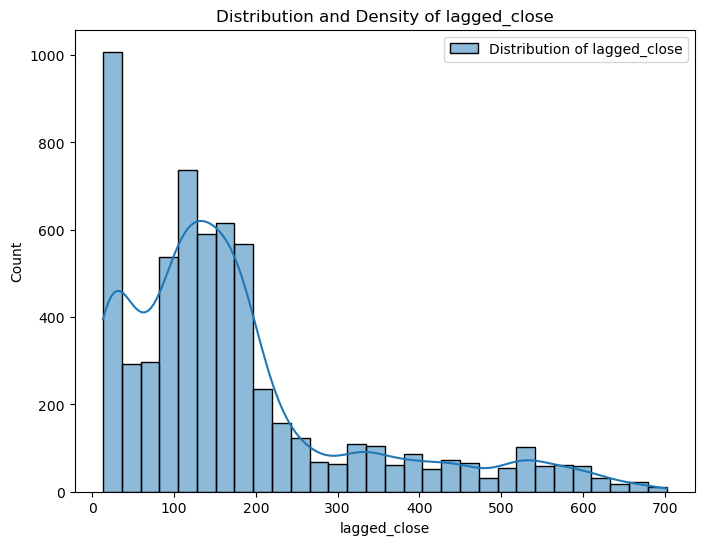

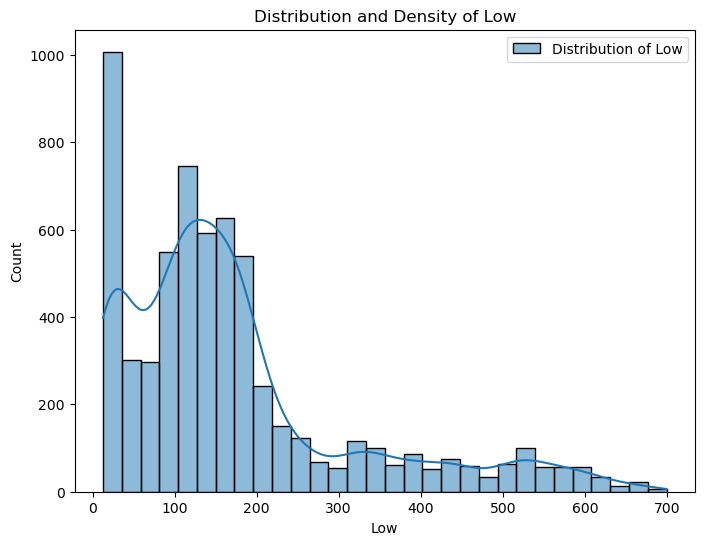

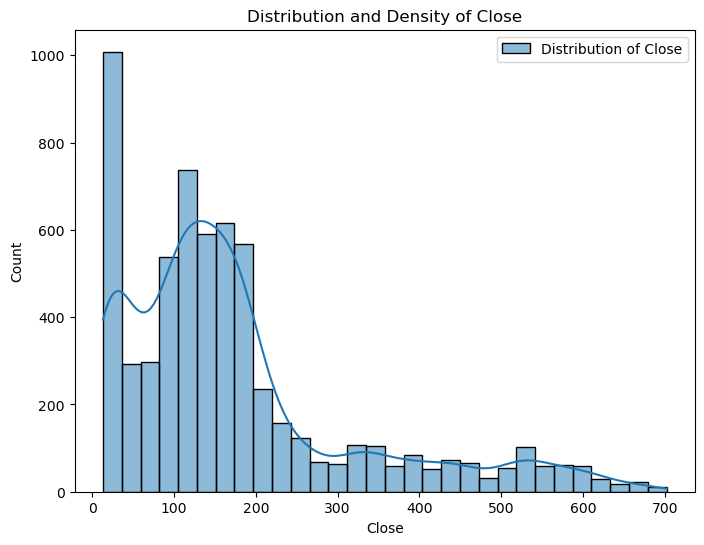

In [34]:
# Distribution plots for selected features
for feature in selected_data.columns[:-1]:  # Exclude the target column
    plt.figure(figsize=(8, 6))
    sns.histplot(selected_data[feature], kde=True, bins=30, label=f'Distribution of {feature}')
    plt.title(f'Distribution and Density of {feature}')
    plt.legend()
    plt.show()

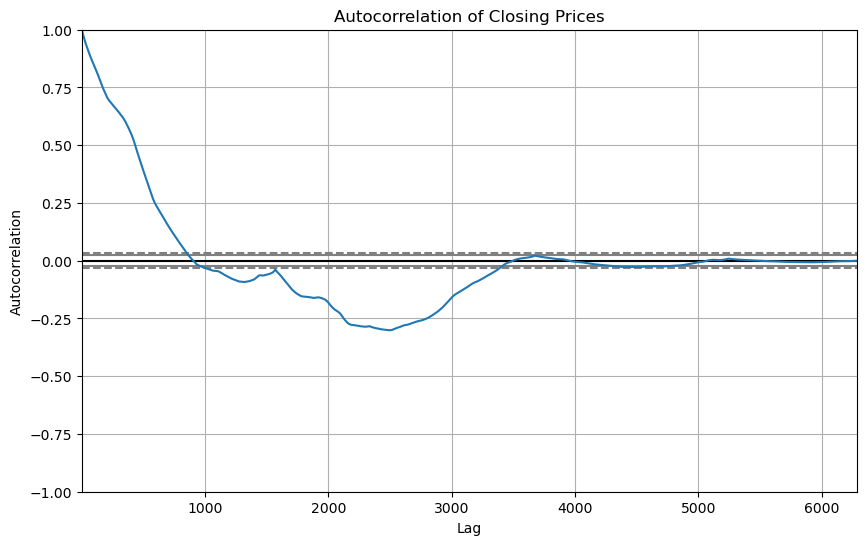

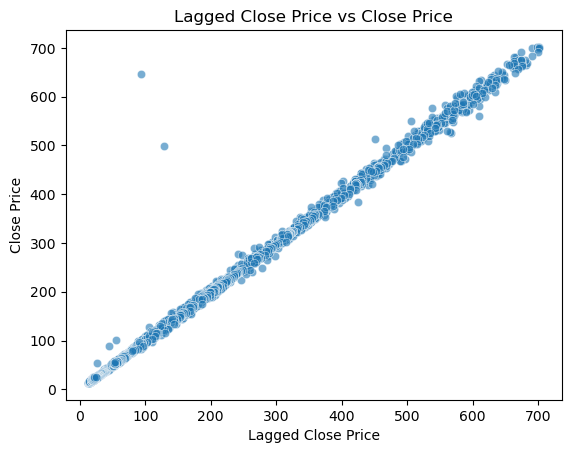

In [35]:
# Autocorrelation plot for stock closing prices
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(selected_data['Close'])
plt.title("Autocorrelation of Closing Prices")
plt.show()

# Scatterplot of lagged prices
sns.scatterplot(x=selected_data['lagged_close'], y=selected_data['Close'], alpha=0.6)
plt.title("Lagged Close Price vs Close Price")
plt.xlabel("Lagged Close Price")
plt.ylabel("Close Price")
plt.show()
